In [1]:
%matplotlib inline
import functools
import gzip
import pandas as pd
import os
import csv
import re
import dateutil
import numpy as np
import pytz
import seaborn as sns
from collections import defaultdict, namedtuple
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib

In [2]:
LOCAL_TZ = pytz.timezone('CET')
BEGIN = dateutil.parser.parse('2022-03-17T00:00:00+01:00').astimezone(LOCAL_TZ)
TIMESTAMP_RE = '\[(?P<timestamp>\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}.\d+Z)\]'
TID_RE =  '\[#tid_(?P<tid>\w+)\]'
matplotlib.rcParams['timezone'] = 'CET'
plt.rcParams["figure.figsize"] = (5,3)

In [3]:
def read_slurm_log(fn):
    part = pd.read_csv(fn, sep='|', parse_dates=['Start', 'End'])
    part['Start'] = part['Start'].apply(lambda v: v.tz_localize('CET'))
    part['End'] = part['End'].apply(lambda v: v.tz_localize('CET'))
    return part

def read_invoker_events(controller_log):
    records = []
    _open = gzip.open if controller_log.endswith('.gz') else open
    with _open(controller_log, 'rt') as f:
        for line in f:
            assert re.match(TIMESTAMP_RE, line)
            line = line.rstrip()
            if m := re.match(f'{TIMESTAMP_RE} \[INFO\] \[#tid_sid_invokerHealth\] \[InvokerPool\] registered a new invoker: (?P<invoker>\w+)', line):
                records.append({
                    'timestamp': dateutil.parser.parse(m.group('timestamp')).astimezone(LOCAL_TZ),
                    'invoker': m.group('invoker'),
                    'event': 'registered'
                })
            elif m := re.match(f'{TIMESTAMP_RE} \[INFO\] \[#tid_sid_invokerHealth\] \[InvokerActor\] (?P<invoker>\w+) is (?P<state>[^ ]+)', line):
                records.append({
                    'timestamp': dateutil.parser.parse(m.group('timestamp')).astimezone(LOCAL_TZ),
                    'invoker': m.group('invoker'),
                    'event': m.group('state')
                })
    df = pd.DataFrame(data=records)
    df['job'] = df['invoker'].apply(lambda invoker: int(invoker[7:]) if invoker.startswith('invoker') else None)
                
    return df

In [4]:
slurm_log = read_slurm_log('slurm-jobs.txt')

In [5]:
invoker_events = read_invoker_events('controller0.log.gz')

In [6]:
matching_invoker_events = slurm_log.join(invoker_events.set_index('job'), on='JobID', how='left')

In [7]:
class MinBuckets:
    def __init__(self, begin):
        self.begin = begin
        self.buckets = np.zeros(60 * 24)
        
    def get_offset(self, date):
        return min(max(int((date - self.begin).total_seconds() // 60), 0), len(self.buckets) - 1)
        
    def inc_range(self, begin, end):
        begin = self.get_offset(begin)
        end = self.get_offset(end)
        for i in range(begin, end):
            self.buckets[i] += 1

def build_stats(df_in):
    stats = {
        'starting': MinBuckets(BEGIN),
        'up': MinBuckets(BEGIN),
        'down': MinBuckets(BEGIN),
    }

    for name, df in df_in.sort_values('timestamp').groupby('JobID'):
        booted = False
        last_time = df.Start.min()
        state = None

        for i, row in df.iterrows():
            if row.event == 'up' and state != 'up':
                # booted up or back online
                stats['down' if booted else 'starting'].inc_range(last_time, row.timestamp)
                state = 'up'
                booted = True
                last_time = row.timestamp
            elif row.event == 'down' and state != 'down':
                stats['up'].inc_range(last_time, row.timestamp)
                last_time = row.timestamp
                state = 'down'
        stop = df.End.max()
        if state is not None and last_time is not None:
            stats[state].inc_range(last_time, stop)
    return stats

stats = build_stats(matching_invoker_events)

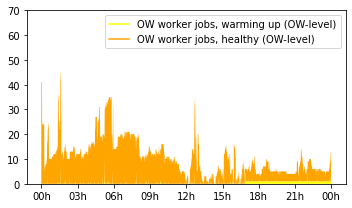

In [8]:
def timestamp_range(start, minutes=60*24):
    res = []
    for i in range(minutes):
        res.append(start)
        start += timedelta(minutes=1)
    return res

def plot_job_statuses(warming_up, healthy, irresponsive, start):
    _, ax = plt.subplots()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%02Hh'))
    ax.set_ylim(0, 70)

    plt.plot([], [], color='yellow', label='OW worker jobs, warming up (OW-level)')
    plt.plot([], [], color='orange', label='OW worker jobs, healthy (OW-level)')
    plt.stackplot(timestamp_range(start), [warming_up, healthy, ], colors=['yellow', 'orange', 'red'])
    plt.legend()
plot_job_statuses(stats['starting'].buckets, stats['up'].buckets, stats['down'].buckets, BEGIN)

plt.tight_layout()
plt.savefig('01 - Fib model analysis - OW-level - Node statuses.pdf', metadata={'CreationDate': None})

In [9]:
pd.Series(stats['up'].buckets).describe()

count    1440.000000
mean       10.387500
std         7.760925
min         0.000000
25%         4.000000
50%         9.000000
75%        14.000000
max        45.000000
dtype: float64

In [10]:
print(f"Minutes w/o healthy invoker: {sum(stats['up'].buckets == 0)}")

Minutes w/o healthy invoker: 24


In [11]:
def get_max_offline_range(df):
    start = None
    best_len = 0
    best_start = None
    for i in range(len(df)):
        if df[i] == 0:
            if not start:
                start = i
        elif start:
            new_len = i - start
            if new_len > best_len:
                best_len = new_len
                best_start = start
            start = None
    return (best_start // 60), (best_start % 60), best_len

print("Longest period without invoker: %d:%d, %d min" % get_max_offline_range(stats['up'].buckets))

Longest period without invoker: 14:19, 7 min


# Invoker availability

In [12]:
def build_invoker_stats(df_in):
    job_stats_df = []
    for name, df in df_in.sort_values('timestamp').groupby('JobID'):
        state = None
        total_time = 0
        last_up = None
        ignore = False

        for i, row in df.iterrows():
            if row.event == 'up' and state != 'up':
                state = 'up'
                last_up = row.timestamp
            elif row.event == 'down' and state != 'down':
                if last_up is None:
                    ignore = True # unable to compute total up time
                    break
                total_time += (row.timestamp - last_up).total_seconds()
                state = 'down'
                last_up = None
                
        ignore |= state != 'down' # skip still running
        if not ignore:
            start, stop = df.Start.min(), df.End.max()
            job_stats_df.append({'JobID': name, 'slurm_duration': (stop - start).total_seconds(), 'total_up': total_time, 'Start': start, 'Stop': stop})
    job_stats_df = pd.DataFrame(data=job_stats_df)
    return job_stats_df
job_stats_df = build_invoker_stats(matching_invoker_events)

In [13]:
print('Invoker avg availability %.1f min' % (job_stats_df.total_up.mean() / 60))
print('Invoker median availability %.1f min' % (job_stats_df.total_up.median() / 60))
print('Invoker 75th perc availability %.1f min' % (job_stats_df.total_up.quantile(0.75) / 60))

Invoker avg availability 23.3 min
Invoker median availability 10.7 min
Invoker 75th perc availability 30.8 min


In [14]:
def get_startup_time(slurm_log, invoker_events):
    df = slurm_log.join(invoker_events.query('event == "up"').sort_values('timestamp').groupby('job').first(), on='JobID', how='left')
    df = df.dropna()
    diff = (df['timestamp'] - df['Start']).apply(lambda v: v.total_seconds()).tolist()
    print(f'Median {np.percentile(diff, 50)}')
    print(f'p75 {np.percentile(diff, 75)}')
    print(f'p95 {np.percentile(diff, 95)}')
    
get_startup_time(slurm_log, invoker_events)

Median 12.4765
p75 15.2925
p95 26.503999999999987
